In [1]:
# Importing libraries
import os
import pandas as pd
import numpy as np

In [2]:
# Function to merge all metadata csv files
def merge_csv_files(input_folder, output_file):
    all_files = [f for f in os.listdir(input_folder) if f.startswith('metadata_page_') and f.endswith('.csv')]
    all_files.sort(key=lambda f: int(f.split('_')[-1].split('.')[0]))  # Ensure the files are sorted

    dataframes = []
    
    for file in all_files:
        df = pd.read_csv(os.path.join(input_folder, file))
        dataframes.append(df)
    
    # Concatenate all DataFrames, aligning columns
    combined_df = pd.concat(dataframes, ignore_index=True, sort=False)
    
    # Save the combined DataFrame to a CSV file
    combined_df.to_csv(output_file, index=False)
    print(f"Combined CSV saved to {output_file}")

In [3]:
# Define the input folder and output file
current_dir = os.getcwd()
input_folder = os.path.join(current_dir, '..', 'data', 'metadata')
output_file = os.path.join(current_dir, '..', 'data', 'all_metadata.csv')

# Merge the CSV files
merge_csv_files(input_folder, output_file)

Combined CSV saved to /Users/eshan23/Library/CloudStorage/OneDrive-TheUniversityofChicago/Summer 2024/Shaoda_Wang_RA/wang-ml/scripts/../data/all_metadata.csv


In [7]:
# Examining the metadata availability across years
# First we extract year from the column "dc.date.issued" if it exists
metadata = pd.read_csv(output_file)
metadata['year'] = metadata['dc.date.issued'].str.extract(r'(\d{4})')
metadata['year'] = metadata['year'].astype(float)

# Table showing the metadata availability across years
metadata['year'].value_counts().sort_index()

year
2000.0     29
2001.0     71
2002.0     83
2003.0    106
2004.0    104
2005.0     90
2006.0     79
2007.0     68
2008.0     74
2009.0     66
2010.0     57
2011.0     51
2012.0     36
2013.0     35
2014.0     30
2015.0     39
2016.0     19
2017.0     14
2018.0     11
2019.0      4
2021.0      4
2022.0      2
2023.0      5
Name: count, dtype: int64

<Axes: title={'center': 'Metadata availability across years'}, xlabel='year'>

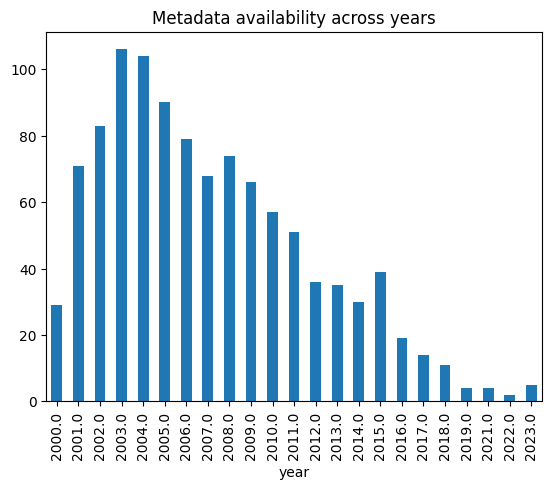

In [8]:
# Plot the metadata availability across years
metadata['year'].value_counts().sort_index().plot(kind='bar', title='Metadata availability across years')

### Key Takeaways:
1. Out of the ~1100 research papers, around 45% are from a 5 year period (2002-2006). 
2. Each of the 5 years from the 2002-2006 period cover between 7-10% of total papers
3. To sample 400 papers from this distribution, we can take multiple approaches:

    * **Unbiased:** 25 random papers from the first 16 years
    * **Biased by completeness**: Given our task, we can give preference to papers who have _AI_ in the field _dc.subject_

In [14]:
# First we sample 25 papers from each of the first 16 years

# Create Research Paper ID if not already present
if 'research_paper_id' not in metadata.columns:
    metadata['research_paper_id'] = metadata.index + 1

# Define number of years to sample from
first_n_years = 16

# Sample 25 papers from each of the first 16 years

# First filter out data that doesn't have a value for year and convert to integer
metadata = metadata[metadata['year'].notnull()]
metadata['year'] = metadata['year'].astype(int)

years_to_sample = range(metadata['year'].min(), metadata['year'].min() + first_n_years)
samples = []
for year in years_to_sample:
    year_df = metadata[metadata['year'] == year]
    sample = year_df.sample(n=min(25, len(year_df)), random_state=1)  # Ensure reproducibility
    samples.append(sample)

metadata_sampled_df_1 = pd.concat(samples)
metadata_sampled_df_1.to_csv(os.path.join(current_dir, '..', 'data', 'metadata_sampled_25_per_year.csv'), index=False)
print("Sampled DataFrame for 25 papers per year created and saved.")

Sampled DataFrame for 25 papers per year created and saved.


In [15]:
# Filter papers that have "AI" in the 'dc.subject' field
ai_papers = metadata[metadata['dc.subject'].str.contains(r'\bAI\b', case=True, na=False, regex=True)]

# Determine the number of additional papers needed to make up 400
additional_papers_needed = 400 - len(ai_papers)

# Randomly sample the remaining papers if needed
if additional_papers_needed > 0:
    remaining_papers = metadata[~metadata['research_paper_id'].isin(ai_papers['research_paper_id'])]
    additional_sample = remaining_papers.sample(n=additional_papers_needed, random_state=1)
    metadata_sampled_df_2 = pd.concat([ai_papers, additional_sample])
else:
    metadata_sampled_df_2 = ai_papers.sample(n=400, random_state=1)

metadata_sampled_df_2.to_csv(os.path.join(current_dir, '..', 'data', 'metadata_sampled_ai_and_random.csv'), index=False)
print("Sampled DataFrame for AI papers and additional random papers created and saved.")

Sampled DataFrame for AI papers and additional random papers created and saved.
